## In this notebook I build a image classifier that achieves 98% accuracy on dogs and cats images.
1. Build a model that predicts dogs and cats.
2. The data used in the notebook is available in Kaggle.com
3. Used a pre-trained VGG model for transfer learning.
4. Showed how the model performence varries in below scenarious.
    1. Train only the last layer of the VGG model.
    2. Train all the three layers of the VGG model.
    3. Use of dropout , batchnormalization , data augmentatation to avoid overfitting.
5. Visualised the performance of the model using confusion matrix and plotting images from various scenarios.
    1. Plot set of correct predictions.
    2. Plot set of incorrect predictions.
    3. Plot set of images where the model was most confident and right.
    4. Plot set of images where the model was most confident and wrong.

## Imports

In [31]:
import imp
import utils;imp.reload(utils)
from utils import *
import os
from shutil import copyfile
from keras.preprocessing import image
from keras.layers import Input,Lambda,Convolution2D,Flatten,Dense,Dropout,BatchNormalization

from keras.utils.np_utils import to_categorical
from keras.optimizers import adam,RMSprop

from sklearn.metrics import confusion_matrix

import bcolz
import keras

%matplotlib inline

In [34]:
print(f'Tensorflow version {tf.__version__}')
print(f'Keras version {keras.__version__}')

Tensorflow version 1.1.0
Keras version 1.2.2


In [2]:
train_path = 'data/dogsandcats/train/'
val_path = 'data/dogsandcats/valid/'
#train_path = 'data/dogsandcats/sample/train/'
#val_path = 'data/dogsandcats/sample/valid/'

## Creating Sample data


In [4]:
%mkdir -p data/dogsandcats/sample/train/cats/
%mkdir -p data/dogsandcats/sample/train/dogs/

In [16]:
%mkdir -p sample/valid/cats/
%mkdir -p sample/valid/dogs/

In [5]:
cd data/dogsandcats/

/home/vishnu/Documents/fastai/data/dogsandcats


In [31]:
f = glob('train/*/*.jpg')
shuffled_f = np.random.permutation(f)
for f in shuffled_f[:2000]:copyfile(f,'sample/'+f)
f = glob('valid/*/*.jpg')
shuffled_f = np.random.permutation(f)
for f in shuffled_f[:500]:copyfile(f,'sample/'+f)

In [39]:
cd ../..

/home/vishnu/Documents/fastai


In [40]:
pwd

'/home/vishnu/Documents/fastai'

## Read Data using Keras data loaders

In [3]:
train_batches = get_batches(train_path)
val_batches = get_batches(val_path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
images , labels = next(train_batches)

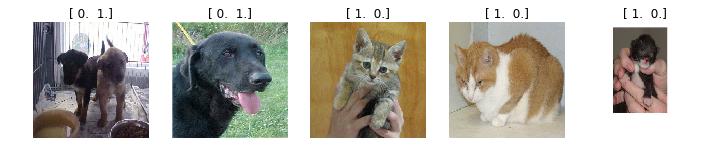

In [5]:
plots(images[:5].astype(np.uint8),labels[:5])

## Train a model using pretrained VGG model

In [37]:
vgg_inp=Input((224,224,3))
vgg = VGG16(input_tensor=Lambda(preproc)(vgg_inp))
#Finetune method used below replaces the last layer in the VGG model and adds a dense layer with
#the desired output number of categories.
vgg = finetune(vgg,2)


In [57]:
fit(vgg,train_batches,val_batches,2)

Epoch 1/2
23000/23000 [==============================] - 196s - loss: 0.0706 - acc: 0.9770 - val_loss: 0.0469 - val_acc: 0.9830
Epoch 2/2
23000/23000 [==============================] - 191s - loss: 0.0461 - acc: 0.9850 - val_loss: 0.0820 - val_acc: 0.9775


In [38]:
fit(vgg,train_batches,val_batches,2)

Epoch 1/2
23000/23000 [==============================] - 205s - loss: 0.0755 - acc: 0.9761 - val_loss: 0.0465 - val_acc: 0.9840
Epoch 2/2
23000/23000 [==============================] - 193s - loss: 0.0422 - acc: 0.9864 - val_loss: 0.0477 - val_acc: 0.9810


## Does changing the last but one layer to trainable help

In [4]:
vgg_inp=Input((224,224,3))
vgg = VGG16(input_tensor=Lambda(preproc)(vgg_inp))
vgg = finetune(vgg,2,1)


In [5]:
fit(vgg,train_batches,val_batches,2)

Epoch 1/2
22976/23000 [============================>.] - ETA: 0s - loss: 0.6425 - acc: 0.9580

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 113s - loss: 0.6421 - acc: 0.9581 - val_loss: 0.3227 - val_acc: 0.9800
Epoch 2/2
23040/23000 [==============================] - 111s - loss: 0.4484 - acc: 0.9718 - val_loss: 0.5088 - val_acc: 0.9683


In [8]:
fit(vgg,train_batches,val_batches,1)

Epoch 1/1
22976/23000 [============================>.] - ETA: 0s - loss: 0.4494 - acc: 0.9721

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 109s - loss: 0.4488 - acc: 0.9721 - val_loss: 0.3701 - val_acc: 0.9771


In [4]:
#Keeping the last 3 layers trainable
vgg_inp=Input((224,224,3))
vgg = VGG16(input_tensor=Lambda(preproc)(vgg_inp))
vgg = finetune(vgg,2,3)

In [5]:
vgg.optimizer.lr = 1e-5

In [7]:
vgg.fit_generator(train_batches,samples_per_epoch=train_batches.n,validation_data=val_batches
                  ,nb_val_samples=val_batches.n,
                  nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 205s - loss: 0.0695 - acc: 0.9748 - val_loss: 0.0347 - val_acc: 0.9850
Epoch 2/2
23000/23000 [==============================] - 192s - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0316 - val_acc: 0.9885


## Saving all the data in the form of Bcolz array for faster ascess

In [8]:
train_data = get_data(train_path)
val_data = get_data(val_path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
save_array(train_data,'data/dogsandcats/train.bc')
save_array(val_data,'data/dogsandcats/valid.bc')

#save_array(train_data,'data/dogsandcats/train_sample.bc')
#save_array(val_data,'data/dogsandcats/valid_sample.bc')



## Loading the data

In [10]:
trn_data = load_array('data/dogsandcats/train.bc')
val_data = load_array('data/dogsandcats/valid.bc')

#trn_data = load_array('data/dogsandcats/train_sample.bc')
#val_data = load_array('data/dogsandcats/valid_sample.bc')

In [11]:
trn_batches = get_batches(train_path,shuffle=False)
val_batches = get_batches(val_path,shuffle=False)

trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_classes = one_hot(trn_classes,2)
val_classes = one_hot(val_classes,2)

trn_classes[:2]

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


array([[ 1.,  0.],
       [ 1.,  0.]])

## Building a simple linear model from the outputs of VGG model

In [12]:
vgg = VGG16()
trn_features = vgg.predict(trn_data)
val_features = vgg.predict(val_data)

In [13]:
lm = Sequential()
lm.add(Dense(2,activation='softmax',input_shape=(1000,)))
lm.compile(optimizer=RMSprop(lr=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
lm.optimizer.lr = 0.00001
lm.fit(trn_features,trn_classes,validation_data=(val_features,val_classes)
       ,batch_size=8,nb_epoch=5)

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 7s - loss: 0.2104 - acc: 0.9402 - val_loss: 0.1934 - val_acc: 0.9460
Epoch 2/5
23000/23000 [==============================] - 6s - loss: 0.1989 - acc: 0.9405 - val_loss: 0.1827 - val_acc: 0.9455
Epoch 3/5
23000/23000 [==============================] - 6s - loss: 0.1896 - acc: 0.9410 - val_loss: 0.1737 - val_acc: 0.9465
Epoch 4/5
23000/23000 [==============================] - 7s - loss: 0.1819 - acc: 0.9416 - val_loss: 0.1664 - val_acc: 0.9465
Epoch 5/5
23000/23000 [==============================] - 6s - loss: 0.1757 - acc: 0.9415 - val_loss: 0.1603 - val_acc: 0.9475


## Validating the model

In [17]:
pred = lm.predict_classes(val_features)
prob = lm.predict_proba(val_features)[:,0]

1600/2000 [=======================>......] - ETA: 0s

In [18]:
val_classes

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [19]:
pred[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [20]:
filenames = val_batches.filenames

In [21]:
n_view = 5

In [22]:
def plot_ids(ids,title):
    plots([image.load_img(val_path+filenames[id]) for id in ids],title)

In [23]:
prob.shape

(2000,)

## Check few images for below conditions 
1. Few correct predictions
2. Few incorrect predictions
3. Model predicted as cat most confidently and it is a cat
4. Model predicted as dog most confidently and it is a dog
5. Model predicted as cat but it is a dog
6. Model predicted as dog but it is a cat
7. Most uncertain labels

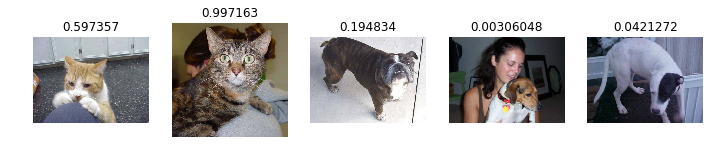

In [25]:
#Few correct predictions 
correct = np.where(pred==val_classes[:,1])[0]
ids = np.random.permutation(correct)[:n_view]
plot_ids(ids,prob[ids])

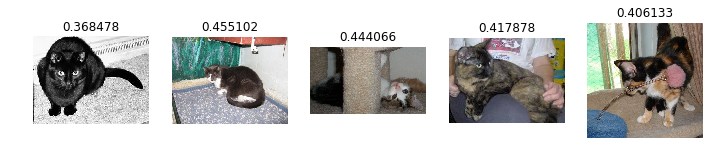

In [26]:
#Few incorrect predictions
incorrect = np.where(pred != val_classes[:,1])[0]
ids = np.random.permutation(incorrect)[:n_view]
plot_ids(ids,prob[ids])

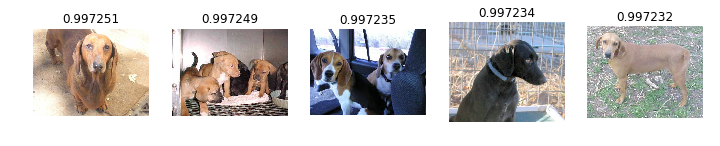

In [27]:
#We predicted as dogs confidentally and they are dogs 
correct_dogs = np.where((pred == 1) & (pred == val_classes[:,1]))[0]
most_correct_dogs = np.argsort(prob[correct_dogs])[:n_view]
plot_ids(correct_dogs[most_correct_dogs],1-prob[correct_dogs][most_correct_dogs])

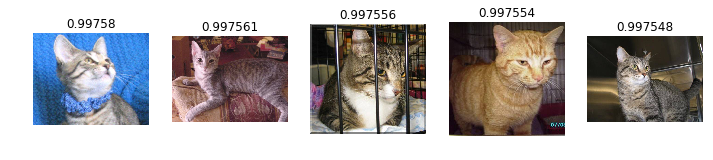

In [28]:
#for cats
correct_cats = np.where((pred==0) & (pred == val_classes[:,1]))[0]
most_correct_cats = np.argsort(prob[correct_cats])[::-1][:n_view]
plot_ids(correct_cats[most_correct_cats],prob[correct_cats][most_correct_cats])

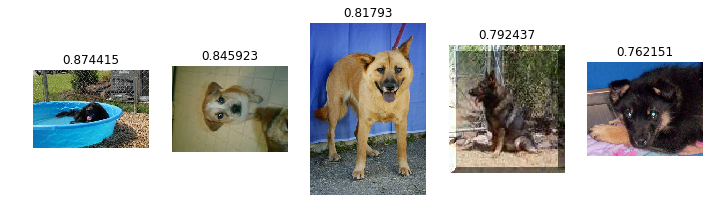

In [29]:
#Predicted as cats but they were dogs
incorrect_cats = np.where((pred == 0) & (pred != val_classes[:,1]))[0]
most_incorrect_cats = np.argsort(prob[incorrect_cats])[::-1][:n_view]
plot_ids(incorrect_cats[most_incorrect_cats],prob[incorrect_cats][most_incorrect_cats])



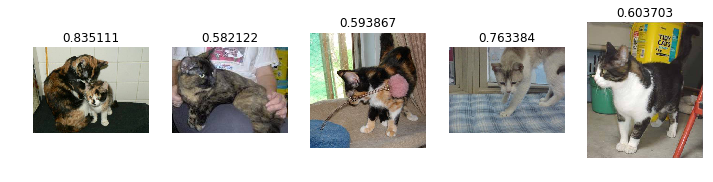

In [30]:
#Predicted as Dogs but they were cats
incorrect_dogs = np.where((pred == 1) & (pred != val_classes[:,1]))[0]
most_incorrect_dogs = np.argsort(incorrect_dogs)[:n_view]
plot_ids(incorrect_dogs[most_incorrect_dogs],1-prob[incorrect_dogs][most_incorrect_dogs])

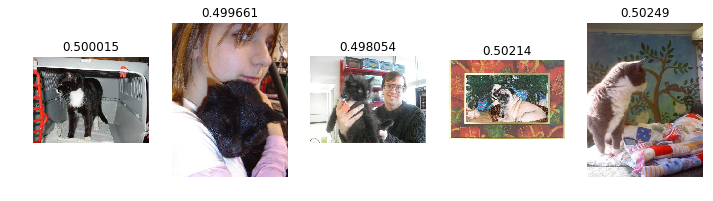

In [31]:
#Model is not sure what is the label
most_uncertain = np.argsort(np.abs(prob-0.5))[:n_view]
plot_ids(most_uncertain,prob[most_uncertain])

In [32]:
correct_cats = len(np.where((pred==0) & (pred == val_classes[:,1]))[0])
total_noof_cats = np.sum(val_classes[:,1]==0)
correct_dogs = len(np.where((pred==1) & (pred == val_classes[:,1]))[0])
total_noof_dogs = len(pred) - total_noof_cats
FP = total_noof_cats-correct_cats
FN = total_noof_dogs-correct_dogs
print(f'TP is {correct_cats}')
print(f'TN is {correct_dogs}')
print(f'FP is {FP}')
print(f'FN is {FN}')
print(f'total {correct_dogs + correct_cats + FP + FN}')

TP is 983
TN is 912
FP is 66
FN is 39
total 2000


In [33]:
cm = confusion_matrix(val_classes[:,1],pred)

[[983  66]
 [ 39 912]]


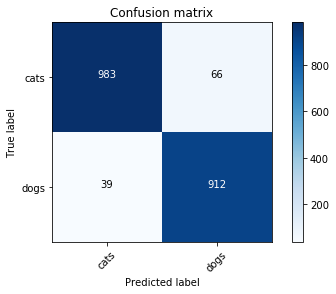

In [34]:
plot_confusion_matrix(cm,val_batches.class_indices)

## Calculate preconvoluted features

In [3]:
train_batches = get_batches(train_path,batch_size=1,shuffle=False,class_mode=None)
val_batches = get_batches(val_path,batch_size=1,shuffle=False,class_mode=None)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
train_labels = one_hot(train_batches.classes,2)
val_labels = one_hot(val_batches.classes,2)

In [18]:
vgg_inp = Input(shape=(224,224,3))
vgg = VGG16(input_tensor=Lambda(preproc)(vgg_inp))

In [19]:
last_conv_idx = [i for i,layer in enumerate(vgg.layers) if type(layer) == Convolution2D][-1]

In [20]:
conv_model = Sequential(vgg.layers[:last_conv_idx+2])

In [43]:
train_conv_features = conv_model.predict_generator(train_batches,train_batches.n)
val_conv_features = conv_model.predict_generator(val_batches,val_batches.n)

In [44]:
save_array(train_conv_features,'data/dogsandcats/train_conv_features.bc')
save_array(val_conv_features,'data/dogsandcats/val_conv_features.bc')

In [7]:
train_conv_features = load_array('data/dogsandcats/train_conv_features.bc')
val_conv_features = load_array('data/dogsandcats/val_conv_features.bc')

## Create a bunch of fully connected layers without dropout

(7, 7, 512)

In [21]:
p = 0.0
fc = Sequential([Flatten(input_shape=conv_model.layers[-1].output_shape[1:]),
                Dense(4096,activation='relu'),
                BatchNormalization(),
                Dropout(p),
                Dense(4096,activation='relu'),
                BatchNormalization(),
                Dropout(p),
                Dense(2,activation='softmax')])
fc.compile(adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
fc.fit(train_conv_features,train_labels,validation_data=(val_conv_features,val_labels),nb_epoch=3)

Train on 2000 samples, validate on 500 samples
Epoch 1/3
2000/2000 [==============================] - 4s - loss: 0.6402 - acc: 0.9175 - val_loss: 0.2974 - val_acc: 0.9580
Epoch 2/3
2000/2000 [==============================] - 4s - loss: 0.0854 - acc: 0.9890 - val_loss: 0.2313 - val_acc: 0.9740
Epoch 3/3
2000/2000 [==============================] - 4s - loss: 0.0687 - acc: 0.9940 - val_loss: 0.2670 - val_acc: 0.97200.9 -


## Data augmentation

In [9]:
gen = image.ImageDataGenerator(rotation_range=40,horizontal_flip=True
                               ,zoom_range=0.3
                               ,height_shift_range=0.2)

In [64]:
img = np.expand_dims(image.load_img('data/dogsandcats/sample/train/cats/cat.2562.jpg'),0)

In [65]:
g = gen.flow(img,batch_size=1)

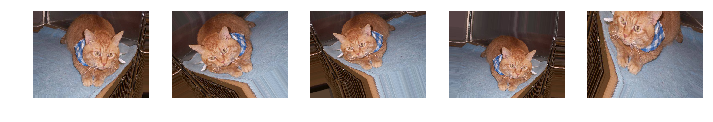

In [66]:
plots([next(g)[0].astype(np.uint8) for i in range(5)])

In [16]:
train_batches = get_batches(train_path,gen)
val_batches = get_batches(val_path,gen)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [22]:
conv_model.add(fc)

In [23]:
for layer in conv_model.layers: 
     if type(layer) == Convolution2D:
        layer.trainable=False 
conv_model.compile(optimizer=adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
conv_model.fit_generator(train_batches,samples_per_epoch=train_batches.n
                  ,validation_data=val_batches
                  ,nb_val_samples=val_batches.n
                  ,nb_epoch=2,nb_worker=2,pickle_safe=True)

Epoch 1/2
22976/23000 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9375

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 130s - loss: 0.1519 - acc: 0.9375 - val_loss: 0.0894 - val_acc: 0.9663
Epoch 2/2
23024/23000 [==============================] - 129s - loss: 0.1081 - acc: 0.9578 - val_loss: 0.0802 - val_acc: 0.9688


In [25]:
conv_model.optimizer.lr = conv_model.optimizer.lr/10

In [26]:
conv_model.fit_generator(train_batches,samples_per_epoch=train_batches.n
                  ,validation_data=val_batches
                  ,nb_val_samples=val_batches.n
                  ,nb_epoch=2,nb_worker=2,pickle_safe=True)

Epoch 1/2
22976/23000 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9620

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 131s - loss: 0.1011 - acc: 0.9621 - val_loss: 0.0802 - val_acc: 0.9722
Epoch 2/2
23024/23000 [==============================] - 130s - loss: 0.0923 - acc: 0.9650 - val_loss: 0.0736 - val_acc: 0.9717


In [27]:
conv_model.optimizer.lr = conv_model.optimizer.lr/10
conv_model.fit_generator(train_batches,samples_per_epoch=train_batches.n
                  ,validation_data=val_batches
                  ,nb_val_samples=val_batches.n
                  ,nb_epoch=2,nb_worker=2,pickle_safe=True)

Epoch 1/2
22976/23000 [============================>.] - ETA: 0s - loss: 0.0838 - acc: 0.9678

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 130s - loss: 0.0836 - acc: 0.9679 - val_loss: 0.0458 - val_acc: 0.9834
Epoch 2/2
23024/23000 [==============================] - 130s - loss: 0.0808 - acc: 0.9692 - val_loss: 0.0794 - val_acc: 0.9697


In [28]:
conv_model.optimizer.lr = conv_model.optimizer.lr * 100
conv_model.fit_generator(train_batches,samples_per_epoch=train_batches.n
                  ,validation_data=val_batches
                  ,nb_val_samples=val_batches.n
                  ,nb_epoch=2,nb_worker=2,pickle_safe=True)

Epoch 1/2
22976/23000 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9716

/home/vishnu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


23040/23000 [==============================] - 130s - loss: 0.0737 - acc: 0.9716 - val_loss: 0.0762 - val_acc: 0.9722
Epoch 2/2
23024/23000 [==============================] - 131s - loss: 0.0750 - acc: 0.9709 - val_loss: 0.0634 - val_acc: 0.9727
